# 第7章 Agent应用与图状态编排框架LangGraph

# 学习目标

1. 掌握 LangGraph 的核心概念和使用场景  
2. 掌握 LangGraph 构建 ReAct Agent  
3. 掌握 LangGraph 创建自定义工作流  
4. 掌握 Memory 与 Persistence

# 1. LangGraph 介绍

# 1.1 基本概述

LangGraph 是由 LangChain 团队开发的一个开源框架，旨在帮助开发者构建基于大型语言模型（LLM）的复杂、有状态、多主体的应用。它通过将工作流表示为图结构（graph），提供了更高的灵活性和控制能力，特别适合需要循环逻辑、状态管理以及多主体协作的场景，比如智能代理（agent）和多代理工作流。

LangGraph 是为智能体和工作流设计的一套底层编排框架，旨在构建、部署和管理复杂的生成式 AI 代理工作流。它提供了一套工具和库，使用户能够以可扩展且高效的方式创建、运行和优化大型语言模型(LLM)。LangGraph 的核心是利用基于图的架构的强大功能来建模和管理 AI 代理工作流中各个组件之间的复杂关系。

官方文档：https://langchain-ai.github.io/langgraph/

# 1.2核心概念

# 图结构（Graph Structure）

LangGraph 将应用逻辑组织成一个有向图，其中：

- 节点 (Nodes) : 代表具体的操作或计算步骤, 可以是调用语言模型、执行函数或与外部工具交互等  
- 边（Edges）：定义节点之间的连接和执行顺序，支持普通边（直接连接）和条件边（基于条件动态选择下一步）

# 状态管理(State Management)

LangGraph 的核心特点是自动维护和管理状态

状态（State）是一个贯穿整个图的共享数据结构，记录了应用运行过程中的上下文信息

每个节点可以根据当前状态执行任务并更新状态，确保系统在多步骤或多主体交互中保持一致性

# 循环能力 (Cyclical Workflows)

与传统的线性工作流（如 LangChain 的 LCEL）不同，LangGraph 支持循环逻辑，这使得它非常适合需要反复推理、决策或与用户交互的代理应用。例如，一个代理可以在循环中不断调用语言模型，直到达成目标。

# 1.3 主要特点

灵活性：开发者可以精细控制工作流的逻辑和状态更新，适应复杂的业务需求

持久性：内置支持状态的保存和恢复,便于错误恢复和长时间运行的任务

多主体协作：允许多个代理协同工作，每个代理负责特定任务，通过图结构协调交互

工具集成：可以轻松集成外部工具（如搜索API）或自定义函数，增强代理能力

- 人性化交互：支持“人机交互”（human-in-the-loop）功能，让人类在关键步骤参与决策

# 1.4使用场景

LangGraph 特别适用于以下场景：

对话代理：构建能够记住上下文、动态调整策略的智能聊天机器人

多步骤任务：处理需要分解为多个阶段的复杂问题，如研究、写作或数据分析

多代理系统：协调多个代理分工合作，比如一个负责搜索信息、另一个负责总结内容的系统

# 1.5 与 LangChain 的关系

- LangGraph 是 LangChain 生态的一部分，但它是独立于 LangChain 的一个模块  
- LangChain 更擅长处理简单的线性任务链（DAG），而 LangGraph 专注于更复杂的循环和多主体场景  
- 你可以单独使用 LangGraph，也可以结合 LangChain 的组件（如提示模板、工具接口）来增强功能

# 2. 快速开始

# 2.1 创建 Agent

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
import json
from langchain_community.chat_models.tongyi import ChatTongyi
from langchain.agents import create_agent
from langgraph.checkpoint.memory import InMemorySaver

def get_weather(city:str) ->str:
    """Get weather from city"""
    return f"它是晴天 {city}!"

checkpoint = InMemorySaver()

model = ChatTongyi(
    model="qwen-max",
    api_key=os.getenv("Ali_KEY"),
    temperature=0
)

agent = create_agent(
     model=model,
    tools=[get_weather],
    checkpointer=checkpoint,
    system_prompt="你是个智能助手"
)

# run agent

config = {
    "configurable":{
        "thread_id":"1"
    }
}

shanghai = agent.invoke(
    {
    "messages":[
        {"role":"user","content":"上海的天气怎么样"}
    ]
    },
    config
)
print(shanghai)

hangzhou = agent.invoke(
    {
    "messages":[
        {"role":"user","content":"杭州怎么样"}
    ]
    },
    config
)

print(hangzhou)

{'messages': [HumanMessage(content='上海的天气怎么样', additional_kwargs={}, response_metadata={}, id='46e41ca8-51fe-4b9e-a76c-c2e8e25fcf42'), AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"city": "上海"}', 'name': 'get_weather'}, 'id': 'call_1f593da37c60456d8b2267', 'index': 0, 'type': 'function'}]}, response_metadata={'model_name': 'qwen-max', 'finish_reason': 'tool_calls', 'request_id': '427738f3-9f3c-4bbe-bdec-653a16035f57', 'token_usage': {'input_tokens': 234, 'output_tokens': 17, 'prompt_tokens_details': {'cached_tokens': 0}, 'total_tokens': 251}}, id='lc_run--019b1a49-0a2c-7431-9d71-b8d8ea3bf1f9-0', tool_calls=[{'name': 'get_weather', 'args': {'city': '上海'}, 'id': 'call_1f593da37c60456d8b2267', 'type': 'tool_call'}]), ToolMessage(content='它是晴天 上海!', name='get_weather', id='d162969b-5100-4fd6-a80b-6e148d9c739b', tool_call_id='call_1f593da37c60456d8b2267'), AIMessage(content='上海今天的天气是晴天。', additional_kwargs={}, response_metadata={'model_name': 'qwen-ma

##  2.2 创建自定义工作流

### 2.2.1 构建一个基本的聊天机器人


In [2]:
import os
import traceback

from dotenv import load_dotenv

load_dotenv()
import json
from typing import Annotated
from langchain_community.chat_models.tongyi import ChatTongyi
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list,add_messages]

In [3]:

# 1. 创建 StateGraph
graph_builder = StateGraph(State)

llm = ChatTongyi(
    model="qwen-max",
    api_key=os.getenv("Ali_KEY"),
    temperature=0
)

def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

# 添加一个 chatbot 节点
graph_builder.add_node("chatbot", chatbot)
# 添加一个 entry 点来告诉图表每次运行时从哪里开始工作
graph_builder.add_edge(START,"chatbot")
# 添加一个 exit 点来只是图表应该在哪里结束
graph_builder.add_edge("chatbot",END)
# 编译图
graph = graph_builder.compile()


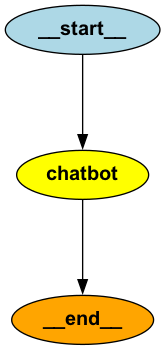

In [4]:
# 可视化图（可选）
from IPython.display import display,Image

try:
    display(Image(graph.get_graph().draw_png()))
except Exception as e:
    print(e)
    pass

In [4]:

# 运行聊天机器人
def steam_graph_updates(user_input:str):
    for event in graph.stream({"messages":[{"role":"user","content":user_input}]}):
        for value in event.values():
            print("Assisant:",value["messages"][-1].content)


while True:
    try:
        user_input = input("User:")
        if user_input.lower() in ["quit","exit","q"]:
            print("Goodbye")
            break
        steam_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User:" + user_input)
        steam_graph_updates(user_input)
        break


User: fds


Assisant: I'm not sure what you mean by "fds." Could you please provide more context or clarify your question? I'd be happy to help if you can give me a bit more information.


User: quit


Goodbye


### 2.2.2 添加工具
安装使用Tavily 搜索引擎

In [8]:
import json
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(
    tavily_api_key=os.getenv("Tavily_KEY"),
    max_results=2)

tools = [tavily_tool]

result = tavily_tool.invoke("什么是 LangGraph ?")

for res in result['results']:
    print(res['content'])


什么是LangGraph ？ LangGraph 是由LangChain 开发的框架，用于管理集成LLM 的应用程序的控制流。 LangGraph 和LangChain 有何不同
LangGraph 是LangChain 最近发布的一个重要功能，宣布LangChain 进入多智能体框架领域。通过建立在LangChain 之上，LangGraph 使开发人员可以轻松创建


# 2.2.3 添加内存记忆

聊天机器人现在可以使用工具来回答用户的问题，但它无法记住之前交互的上下文。这限制了它进行连贯、多轮对话的能力。

LangGraph 通过持久化检查点checkpoint解决了这个问题。如果您在编译图时提供，并thread_id在调用图时提供，LangGraph会在每一步之后自动保存状态。当您再次使用相同的调用图时thread_id，图会加载其已保存的状态，从而允许聊天机器人从上次中断的地方继续执行。



In [6]:
import os
import traceback

from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode

load_dotenv()
import json
from typing import Annotated
from langchain_community.chat_models.tongyi import ChatTongyi
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import InMemorySaver

# 这是内存检查点，这对于本教程来说很方便
# 但是在生产环境中，需要将其改为 sqliterServer PostgresServer 或者 redis server 数据库
memory = InMemorySaver()

class State(TypedDict):
    messages: Annotated[list,add_messages]

# 1. 创建 StateGraph
graph_builder = StateGraph(State)

llm = ChatTongyi(
    model="qwen-max",
    api_key=os.getenv("Ali_KEY"),
    temperature=0
)

def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

# 添加一个 chatbot 节点
graph_builder.add_node("chatbot", chatbot)

def route_tools(state:State):
    """
     Use in conditional_edge to route to the ToolNode if the last message
     has tool calls. Otherwise,rotue to the end.
    """
    if isinstance(state,list):
        ai_message = state[-1]
    elif messages := state.get("messages",[]):
        ai_message = messages[-1]
    else:
        raise TypeError(f"No messages found in input state to tool_edge:{state}")
    if hasattr(ai_message,"tool_calls") and len(ai_message.tool_calls)>0:
        return "tools"
    return END

# 添加一个 entry 点来告诉图表每次运行时从哪里开始工作
graph_builder.add_edge(START,"chatbot")
# 添加一个 exit 点来只是图表应该在哪里结束
graph_builder.add_edge("chatbot",END)

config = {
    "configurable":{
        "thread_id":"1"
    }
}

# 编译图
graph = graph_builder.compile(checkpointer=memory)

while True:
    try:
        user_input = input("User:")
        if user_input.lower() in ["quit","exit","q"]:
            print("Goodbye")
            break
        events = graph.stream(
            {"messages": [
                {"role": "user", "content": user_input},
            ]},
            config,
            stream_mode="values"
        )
        for event in events:
            event["messages"][-1].pretty_print()
    except:
        # fallback if input() is not available
        break



User: quit


Goodbye


# 3. 持久化状态

LangGraph 内置了一个持久化层，通过检查点(checkpointer)机制实现。当你使用检查点器编译图时，它会在每个超级步骤(super-step)自动保存图状态的检查点。这些检查点被存储在一个线程 thread)中，可在图执行后随时访问。由于线程允许在执行后访问图的状态，因此实现了人工介入（human-in-the-loop）、记忆（memory）、时间回溯（time travel）和容错（fault-tolerance）等强大功能。


# 3.1 什么是记忆 (Memory)

记忆是一种认知功能，允许人们存储、检索和使用信息来理解他们的现在和未来。通过记忆功能，代理可以从反馈中学习，并适应用户的偏好。

- 短期记忆（Short-term memory）或称为线程范围内的记忆，可以在与用户的单个对话线程中的任何时间被回忆起来。LangGraph将短期记忆管理为代理状态的一部分。状态会被使用检查点机制保存到数据库中，以便对话线程可以在任何时间恢复。当图谱被调用或者一个步骤完成时，短期记忆会更新，并且在每个步骤开始时读取状态。这种记忆类型使得AI能够在与用户的持续对话中保持上下文和连贯性，确保了交互的流畅性和效率。例如，在一系列的询问、回答或命令执行过程中，用户无需重复之前已经提供的信息，因为AI能够记住这些细节并根据需要利用这些信息进行响应或进一步的操作。这对于提升用户体验，尤其是复杂任务处理过程中的体验至关重要。

- 长期记忆（Long-term memory）是在多个对话线程之间共享的。它可以在任何时间、任何线程中被回忆起来。记忆的范围可以限定在任何自定义命名空间内，而不仅仅局限于单个线程ID。LangGraph提供了存储机制，允许您保存和回忆长期记忆。这种记忆类型使得AI能够在不同对话或用户交互中保留和利用信息。例如，用户的偏好、历史记录或特定的上下文信息可以跨会话保存下来，并在未来的任何交互中被调用。这种方式为用户提供了一种无缝体验，无论他们何时或以何种方式与AI交互，AI都能根据过去的信息做出更个性化、更智能的响应。这对于构建深度用户关系和增强系统适应性至关重要。

![](./img/1.png)


# 3.2持久化（Persistence）

许多AI应用需要记忆功能来在多次交互中共享上下文。在LangGraph中，这种类型的记忆可以通过线程级别的持久化添加到任何StateGraph中。通过使用线程级别的持久化，LangGraph允许AI在与用户的连续对话或交互过程中保持信息的连贯性和一致性。这意味着，在一个交互中获得的信息可以被保存并在后续的交互中使用，极大地提升了用户体验。例如，用户在一个会话中表达的偏好可以在下一个会话中被记住和引用，使得交互更加个性化和高效。这种方法对于需要处理复杂或多步骤任务的应用特别有用，因为它确保了用户无需重复提供相同的信息，同时也让AI能够更好地理解和响应用户的需求。



# 5. LangGraph 中使用 InMemoryStore

InMemoryStore是一个基于内存的存储系统，用于在程序运行时临时保存数据。它通常用于快速访问和存储短期记忆或会话数据。我们可以使用使用 langgraph 和 langchain_openai 库来创建一个基于内存的存储系统(InMemoryStore)，并结合 OpenAI 的嵌入模型 (OpenAIEmbeddings) 来处理嵌入向量。

大家可能有疑惑，我们不是用了MemorySaver持久化消息吗，为啥还要用InMemoryStore，他们的主要区别在于数据的持久性和应用场景。InMemoryStore主要用于短期、临时的数据储，强调快速访问；而MemorySaver则侧重于将数据从临时存储转移到持久存储，确保数据可以在多次程序执行间保持不变。在我们设计系统时，可以根据具体需求选择合适的存储策略。对于只需要在会话内保持的数据，可以选择InMemoryStore；而对于需要长期保存并能够在不同会话间共享的数据，则应考虑使用MemorySaver或其他形式的持久化存储解决方案。

下面给大家展示一个结合两种方式的例子，我们实现了一个对话模型的调用逻辑，通过从存储系统中检索与用户相关的记忆信息并将其作为上下文传递给模型，同时支持根据用户指令存储新记忆，确保每个用户的记忆数据独立且自包含，从而提升对话的个性化和连贯性。





In [5]:
import os
import traceback

from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode

load_dotenv()
import json
from typing import Annotated
from langchain_community.chat_models.tongyi import ChatTongyi
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import  InMemoryStore
from langchain_community.embeddings import DashScopeEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore
import uuid
from langchain_core.runnables import RunnableConfig

# 这是内存检查点，这对于本教程来说很方便
# 但是在生产环境中，需要将其改为 sqliterServer PostgresServer 或者 redis server 数据库

memory = InMemorySaver()
in_memory_store = InMemoryStore(
    index={
        "embed": DashScopeEmbeddings(
            model="text-embedding-v1",
            dashscope_api_key=os.getenv("Ali_KEY"),
        ),
        "dims":1536
    }
)

llm = ChatTongyi(
    model="qwen-max",
    api_key=os.getenv("Ali_KEY"),
    temperature=0
)

def call_model(state:MessagesState,config:RunnableConfig,*,store:BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("memories",user_id)
    memories = store.search(namespace,query=str(state["messages"][-1].content))
    info = "\n".join([d.value["data"] for d in memories])
    system_msg = f"You are a helpfull assisant talking to the user.User info: {info}"
    # Store new memories if the user asks the model to remember
    last_message = state["messages"][-1]
    if "remember" in last_message.content.lower():
        memory = "User name is lojzes"
        store.put(namespace,str(uuid.uuid4()),{"data":memory})

    response = llm.invoke(
        [{"role":"system","content":system_msg}] + state["messages"],
    )
    return {"messages":response}

builder = StateGraph(MessagesState)
builder.add_node("call_model",call_model)
builder.add_edge(START,"call_model")
graph = builder.compile(checkpointer=MemorySaver(),store=in_memory_store)

config = {"configurable":{"thread_id":"1","user_id":"1"},}
input_message = {"role":"user","content":"我是 lojzes"}
for chunk in graph.stream({"messages":[input_message]},config,stream_mode="values"):
    chunk["messages"][-1].pretty_print()


config = {"configurable":{"thread_id":"1","user_id":"1"},}
input_message = {"role":"user","content":"我是谁"}
for chunk in graph.stream({"messages":[input_message]},config,stream_mode="values"):
    chunk["messages"][-1].pretty_print()



/opt/anaconda3/envs/7_langGraph_Agent/lib/python3.11/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
/opt/anaconda3/envs/7_langGraph_Agent/lib/python3.11/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


================================ Human Message =================================

我是 lojzes
================================== Ai Message ==================================

你好，lojzes！很高兴见到你。请问有什么我可以帮你的吗？或者你想聊些什么话题呢？
================================ Human Message =================================

我是谁
================================== Ai Message ==================================

你刚才告诉我你是 lojzes。如果你还有其他想了解的或者想聊的话题，随时告诉我哦！


# 6 实现RAG

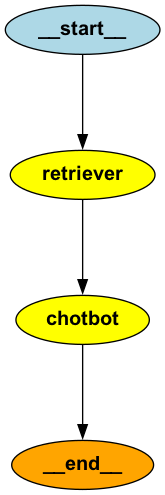

In [7]:
import os
import traceback

from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode

load_dotenv()
import json
from typing import Annotated
from langchain_community.chat_models.tongyi import ChatTongyi
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore
from langchain_community.embeddings import DashScopeEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore
import uuid
from langchain_core.runnables import RunnableConfig
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader('./LangGraph.pdf')
pages = loader.load_and_split()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=200,
    length_function=len,
    add_start_index=True
)
texts = text_splitter.create_documents(
    [page.page_content for page in pages],
)

# 灌库
embeddings = DashScopeEmbeddings(
    dashscope_api_key=os.getenv("Ali_KEY"),
    model="text-embedding-v1",
)
db = FAISS.from_documents(texts, embeddings)
# 检索 top-5
retriever = db.as_retriever(search_kwargs={"k": 5})

from langchain_core.prompts import ChatPromptTemplate,HumanMessagePromptTemplate

template = """
请根据对话历史和下面提供的信息回答上面用户提出的问题:
{query}
"""
prompt = ChatPromptTemplate(
    [
        HumanMessagePromptTemplate.from_template(template),
    ]
)

def retriever(state:MessagesState):
    user_query = ""
    if len(state["messages"]) >= 1:
        # 获取最后一轮用户输入
        user_query = state["messages"][-1]
    else:
        return {"messages": []}
    #检索
    docs = retriever.invoke(str(user_query))
    #填充 prompt 模板
    messages = prompt.invoke("\n".join([doc.content for doc in docs])).messages
    return {"messages": messages}


def chatbot(state:MessagesState):
    return {"messages":[llm.invoke(state["messages"])]}


graph_builider = StateGraph(MessagesState)
graph_builider.add_node("retriever",retriever)
graph_builider.add_node("chotbot",chatbot)

graph_builider.add_edge(START,"retriever")
graph_builider.add_edge("retriever","chotbot")
graph_builider.add_edge("chotbot",END)

graph = graph_builider.compile()

# 可视化图（可选）
from IPython.display import display,Image

try:
    display(Image(graph.get_graph().draw_png()))
except Exception as e:
    pass



# 加入分支：若找不到答案则转人工处理

/opt/anaconda3/envs/7_langGraph_Agent/lib/python3.11/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
/opt/anaconda3/envs/7_langGraph_Agent/lib/python3.11/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


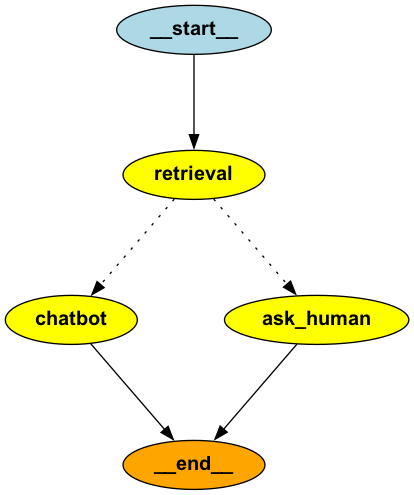

User: 什么是 langGgraph


Assistant: LangGraph 是一个用于构建有状态的多参与者应用程序的库，它利用大型语言模型 (LLM) 来创建代理和多代理工作流。与传统的基于有向无环图（DAG）的解决方案不同，LangGraph 提供了循环性、可控性和持久性的支持，使得定义涉及循环的过程变得更为容易，这对于许多需要复杂交互的应用场景来说是非常重要的。

### LangGraph 的核心组件

- **Graphs (图)**: 代表整个流程或应用逻辑的结构。
- **State (状态)**: 用于存储和管理每个节点或边的状态信息。
- **Nodes (节点)**: 表示流程中的各个步骤或操作单元。其中特别提到了 `START` 节点作为流程开始的地方，以及 `END` 节点作为流程结束的地方。
- **Edges (边)**: 连接节点之间的路径，可以是普通边直接连接两个节点，也可以是条件边根据某些条件决定下一步走向哪个节点。

### 主要功能特点

- **循环能力**: 支持定义包含循环的流程，这在很多实际应用中是必要的，比如对话系统中可能需要反复询问用户直到获得所需信息为止。
- **高度可控**: 用户可以通过配置各种参数来精确控制流程的行为，包括但不限于设置条件分支、自定义入口点等。
- **持久化支持**: 允许将状态保存下来，以便于跨会话使用或者恢复之前的工作进度。

### 应用场景

LangGraph 特别适合于开发那些需要处理复杂对话逻辑、需要多个参与者之间进行协调互动的应用程序。例如，在客服机器人、虚拟助手等领域，LangGraph 可以帮助开发者更高效地实现这些功能，并且保持良好的用户体验。

### 官方资源

对于想要深入了解 LangGraph 的开发者来说，建议访问其[官方文档](https://langchain-ai.github.io/langgraph/)，那里提供了详细的指南、API 文档以及示例代码，有助于快速上手并充分利用该工具的强大功能。


User: exit


In [1]:
import os
import traceback

from dotenv import load_dotenv
from langchain_classic.chains import llm
from langchain_core.messages import AIMessage
from langgraph.prebuilt import ToolNode

load_dotenv()
import json
from typing import Annotated
from langchain_community.chat_models.tongyi import ChatTongyi
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore
from langchain_community.embeddings import DashScopeEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore
import uuid
from langchain_core.runnables import RunnableConfig
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader('./LangGraph.pdf')
pages = loader.load_and_split()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=200,
    length_function=len,
    add_start_index=True
)
texts = text_splitter.create_documents(
    [page.page_content for page in pages],
)

llm = ChatTongyi(
    model="qwen-max",
    api_key=os.getenv("Ali_KEY"),
    temperature=0
)

# 灌库
embeddings = DashScopeEmbeddings(
    dashscope_api_key=os.getenv("Ali_KEY"),
    model="text-embedding-v1",
)
db = FAISS.from_documents(texts, embeddings)
# 检索 top-5
retriever = db.as_retriever(search_kwargs={"k": 5})

from langchain_core.prompts import ChatPromptTemplate,HumanMessagePromptTemplate

template = """
请根据对话历史和下面提供的信息回答上面用户提出的问题:
{query}
"""
prompt = ChatPromptTemplate(
    [
        HumanMessagePromptTemplate.from_template(template),
    ]
)

def retrieval(state:MessagesState):
    user_query = ""
    if len(state["messages"]) >= 1:
        # 获取最后一轮用户输入
        user_query = state["messages"][-1]
    else:
        return {"messages": []}
    #检索
    docs = retriever.invoke(str(user_query))
    #填充 prompt 模板
    messages = prompt.invoke("\n".join([doc.page_content for doc in docs])).messages
    return {"messages": messages}


def chatbot(state:MessagesState):
    return {"messages":[llm.invoke(state["messages"])]}


# graph_builider = StateGraph(MessagesState)
# graph_builider.add_node("retriever",retriever)
# graph_builider.add_node("chotbot",chatbot)
#
# graph_builider.add_edge(START,"retriever")
# graph_builider.add_edge("retriever","chotbot")
# graph_builider.add_edge("chotbot",END)
#
# graph = graph_builider.compile()

# 可视化图（可选）
# from IPython.display import display,Image
#
# try:
#     display(Image(graph.get_graph().draw_png()))
# except Exception as e:
#     pass


from langchain_classic.schema import HumanMessage
from typing import Literal
from langgraph.types import interrupt,Command

# 校验
def verify(state:MessagesState)->Literal["chatbot","ask_human"]:
    messages = HumanMessage("请根据对话历史和上面提供的信息判断，已知的的信息是否能回答用户的问题，直接输出你的判断'Y'或者'N'")
    ret = llm.invoke(state["messages"]+[messages])
    if 'Y' in ret.content:
        return "chatbot"
    else:
        return "ask_human"


# 人工处理
def ask_human(state:MessagesState):
    user_query = state["messages"][-2].content
    human_response = interrupt(
        {
            "question":user_query,
        }
    )
    # Update the state with the human input or route the graph based on the input
    return {
        "messages":[AIMessage(human_response)],
    }


def chatbot(state:MessagesState):
    return {"messages":[llm.invoke(state["messages"])]}


memory = MemorySaver()

graph_builder = StateGraph(MessagesState)
graph_builder.add_node("retrieval",retrieval)
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_node("ask_human",ask_human)

graph_builder.add_edge(START,"retrieval")
graph_builder.add_conditional_edges("retrieval",verify)
graph_builder.add_edge("ask_human",END)
graph_builder.add_edge("chatbot",END)

# 中途会被转人工，所以需要 checkpointer 存储状态
graph = graph_builder.compile(checkpointer=memory)

# 可视化图（可选）
from IPython.display import display,Image

try:
    display(Image(graph.get_graph().draw_png()))
except Exception as e:
    pass

thead_config = {
    "configurable":{
        "thread_id":"1"
    }
}

def stream_graph_updates(user_input:str):
    # 向 graph 传入一条消息（触发状态跟新 add_messages）
    for event in graph.stream(
            {"messages":[
                {"role":"user","content":user_input},
            ]},
            thead_config
    ):
        for value in event.values():
            if isinstance(value, tuple):
                return value[0].value["question"]
            elif "messages" in value and isinstance(value["messages"][-1], AIMessage):
                print("Assistant:",value["messages"][-1].content)
    return None

def resume_graph_updates(human_input:str):
    for event in graph.stream(
        Command(resume=human_input),thead_config,stream_mode="updates"
    ):
        for value in event.values():
            if "messages" in value and isinstance(value["messages"][-1], AIMessage):
                print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User:")
        if user_input == "exit":
            break
        question = stream_graph_updates(user_input)
        if question:
            human_answer = input("Ask Human:" + question + "\nHuman: ")
            resume_graph_updates(human_answer)
    except Exception as e:
        traceback.print_exc()

# 检索增强生成 (RAG) 简介

将大型语言模型的强大功能与外部知识检索相结合，从而生成更准确、更贴近事实、更符合语境的响应。RAG的核心是“使用LLM回答用户查询，但答案基于从知识库检索到的信息”。

# 为什么使用 RAG?

与使用原始或微调的LLM相比，RAG具有几个显著的优势：

1. 事实基础：通过将反应锚定在检索到的事实中来减少幻觉  
2. 领域专业化：无需模型再训练即可提供特定领域的知识  
3. 知识新近度：允许访问超出模型训练截止范围的信息  
4. 透明度：允许引用生成内容的来源  
5. 控制：对模型可以访问的信息进行细粒度的控制

![](./img/2.png)

# Agentic RAG 的主要优势

拥有检索工具的代理可以：

1. 制定优化查询：代理可以将用户问题转换为易于检索的查询  
2. 执行多次检索：代理可以根据需要迭代检索信息  
3. 对检索到的内容进行推理：代理可以从多个来源进行分析、综合并得出结论  
4. 自我批评和改进：代理可以评估检索结果并调整其方法

这种方法自然地实现了先进的RAG技术：

- Hypothetical Document Embedding (HyDE): 代理不直接使用用户查询，而是制定检索优化查询  
- Self-Query Refinement: 代理可以分析初始结果，并使用细化查询执行后续检索



In [4]:
import os
import traceback

from dotenv import load_dotenv
from langchain_classic.chains import llm
from langchain_core.messages import AIMessage
from langgraph.prebuilt import ToolNode

load_dotenv()
import json
from typing import Annotated
from langchain_community.chat_models.tongyi import ChatTongyi
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore
from langchain_community.embeddings import DashScopeEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore
import uuid
from langchain_core.runnables import RunnableConfig
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.prompts import ChatPromptTemplate,HumanMessagePromptTemplate

# 1.加载语料
loader = PyMuPDFLoader('./LangGraph.pdf')
pages = loader.load_and_split()

# 2.缺票
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=200,
    length_function=len,
    add_start_index=True
)
texts = text_splitter.create_documents(
    [page.page_content for page in pages],
)

#  4.灌库
embeddings = DashScopeEmbeddings(
    dashscope_api_key=os.getenv("Ali_KEY"),
    model="text-embedding-v1",
)
db = FAISS.from_documents(texts, embeddings)
# 5.检索 top-5
retriever = db.as_retriever(search_kwargs={"k": 5})

# 6.创建检索工具
from langchain_core.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_books_tools","查找 LangGraph相关资料从本地文档中"
)

# 测试工具
retriever_tool.invoke({
    "query":"什么是 LangGraph 的普通边？"
})

'LangGraph 核心组件: Graphs, State,\nNodes, Edges\n \nLangGraph 核心组件: Graphs, State, Nodes, Edges\nLangGraph\n主要功能\nLangGraph 平台\nGraph(图)\nStateGraph\nCompiling your graph(编译你的图)\nState(状态)\nNodes(节点)\nSTART 节点\nEND 节点\nEdges(边)\n普通边\n条件边\n入口点\n条件入口点\n\xa0\nLangGraph\n \n🦜🕸 LangGraph ⚡ 以图的方式构建语言代理 ⚡\n官方文档地址：https://langchain-ai.github.io/langgraph/\nLangGraph 是一个用于构建有状态的多参与者应用程序的库，利用 LLM 创建代理和多代理工作流。与\n其他 LLM 框架相比，它提供了以下核心优势：循环性、可控性和持久性。LangGraph 允许您定义涉及\n循环的流程，这对于大多数代理架构至关重要，使其与基于 DAG 的解决方案区别开来。作为一个非常底\n\n自于 LangGraph 如何管理 状态。需要强调的是：节点 和 边 不再是 Python 函数——它们可以包含 \nLLM 或简单的 Python 代码。\n简而言之：节点完成工作。边指示下一步要做什么。\nLangGraph 的底层图算法使用消息传递来定义一个通用程序。当一个节点完成其操作时，它会沿着一条\n或多条边向其他节点发送消息。这些接收节点然后执行其函数，将结果消息传递给下一组节点，并且该\n过程继续进行。受到 Google 的 Pregel 系统的启发，该程序以离散的“超级步骤”进行。\n超级步骤可以被认为是图节点上的单个迭代。并行运行的节点属于同一个超级步骤，而顺序运行的节点\n则属于不同的超级步骤。在图执行开始时，所有节点都处于 inactive 状态。当节点在任何传入边（或“通\n道”）上收到新消息（状态）时，它将变为 active 状态。然后，活动节点运行其函数并响应更新。在每个\n超级步骤结束时，没有传入消息的节点通过将其标记为 inactive 来投票 halt。当所有节点都处于 \ninactive 状态且没有消息在传输中时，图执行终止。\

In [5]:
import os
import traceback

from dotenv import load_dotenv
from langchain_classic.chains import llm
from langchain_core.messages import AIMessage
from langgraph.prebuilt import ToolNode

load_dotenv()
import json
from typing import Annotated
from langchain_community.chat_models.tongyi import ChatTongyi
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore
from langchain_community.embeddings import DashScopeEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore
import uuid
from langchain_core.runnables import RunnableConfig
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.prompts import ChatPromptTemplate,HumanMessagePromptTemplate

# 1.加载语料
loader = PyMuPDFLoader('./LangGraph.pdf')
pages = loader.load_and_split()

# 2.缺票
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=200,
    length_function=len,
    add_start_index=True
)
texts = text_splitter.create_documents(
    [page.page_content for page in pages],
)

#  4.灌库
embeddings = DashScopeEmbeddings(
    dashscope_api_key=os.getenv("Ali_KEY"),
    model="text-embedding-v1",
)
db = FAISS.from_documents(texts, embeddings)
# 5.检索 top-5
retriever = db.as_retriever(search_kwargs={"k": 5})

# 6.创建检索工具
from langchain_core.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_books_tools","查找 LangGraph相关资料从本地文档中"
)

# 测试工具
retriever_tool.invoke({
    "query":"什么是 LangGraph?"
})


# 生成查询
llm = ChatTongyi(
    model="qwen-max",
    api_key=os.getenv("Ali_KEY"),
    temperature=0
)

def generate_query_or_response(state:MessagesState):
    response = (
        llm.bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

# 随机输入
# input = {"messages":[{"role":"user","content":"hello!"}]}
# generate_query_or_response(input)["messages"][-1].pretty_print()

# 提出一个需要语义搜索的问题：

input = {"messages":[{"role":"user","content":"什么是 langGraph 的条件边？"}]}
generate_query_or_response(input)["messages"][-1].pretty_print()



================================== Ai Message ==================================
Tool Calls:
  retriever_books_tools (call_0ae68f7a1b23403b96c0e3)
 Call ID: call_0ae68f7a1b23403b96c0e3
  Args:
    query: 条件边


# 4. 对检索结果文档进行评分

1）添加条件边 grade Documents，用于判断检索到的文档是否与问题相关。我们将使用一个具有结构化输出模式的模型 Grade Documents进行文档评分。该函数将根据评分决策（或）grade Documents返回要前往的节点名称：generate_answerRewrite_question
2）


In [6]:

# 对检索结果文档进行评分
from pydantic import  BaseModel,Field
from typing import Literal

grade_prompt = (
"你是一个评审员，负责评估检索到的文档与用户问题的相关性。\n"
"以下是检索到的文档:\n\n"
"{context} \n\n"
"以下是用户问题:{question}\n"
"如果文档包含与用户问题相关的关键字或语义含义，将其评为相关。\n"
"给出一个二元评分 'yes' 或 'no'，以指示文档是否与问题相关。"
)

class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance checking."""
    binary_score :str = Field(description="Relevance score : 'yes' if relevant,or 'no' if not relevant")


def grade_documents(state:MessagesState) -> Literal["generate_answer","rewriter_question"]:
    """Determine whether the reterieved document is relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = grade_prompt.format(question=question,context=context)
    response = (
        llm.with_structured_output(GradeDocuments).invoke([HumanMessage(content=prompt)])
    )
    score = response.binary_score
    if score == "yes":
        return "generate_answer"
    else:
        return "rewriter_question"


 # 测试  grade_documents
from langchain_core.messages import convert_to_messages
input = {
    "messages": convert_to_messages(
        [{
            "role":"user",
            "content":"什么是 LangGraph"
        },
        {
            "role":"assistant",
            "content":"",
            "tool_calls":[
                {
                    "id":"1",
                    "name":"retriever_books_tools",
                    "args":{
                        "query":"什么是 LangGraph"
                    }
                }
            ]
        },
        {
            "role":"tool","content":"LangGraph","tool_call_id":"1"
        }]
    )
}
print(grade_documents(input))


generate_answer


# 5. 问题重写

1）构建rewrite_question节点。检索工具可能会返回一些可能不相关的文档，这表明需要改进原始用户问题。为此，我们将该rewrite_question节点称为：



In [7]:

# 问题重写
rewrite_prompt = (
"查看输入内容并尝试推理其潜在的语义意图/含义。\n\n"
"这是初始问题：\n"
" \n------- \n"
"{question}"
" \n------- \n"
"提出一个改进后的问题："
)
def rewrite_question(state:MessagesState):
    """重写用户原始的问题"""
    messages= state["messages"]
    question = messages[0].content
    prompt = rewrite_prompt.format(question=question)
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"messages": [{"role":"user","content":response.content}]}


input = {
    "messages": convert_to_messages(
        [{
            "role":"user",
            "content":"什么是 LangGraph"
        },
        {
            "role":"assistant",
            "content":"",
            "tool_calls":[
                {
                    "id":"1",
                    "name":"retriever_books_tools",
                    "args":{
                        "query":"什么是 LangGraph"
                    }
                }
            ]
        },
        {
            "role":"tool","content":"newsf","tool_call_id":"1"
        }]
    )
}
print(rewrite_question(input))



{'messages': [{'role': 'user', 'content': '从初始问题“什么是 LangGraph”来看，提问者可能是在询问一个特定的概念、技术或工具。然而，“LangGraph”这个词并不是非常常见，它可能是某个特定领域内的术语，或者是一个新出现的技术名词。\n\n**潜在的语义意图/含义：**\n1. **技术相关查询**：提问者可能在寻找关于某种与语言处理相关的图形表示方法的信息。例如，在自然语言处理（NLP）领域，有时候会使用图结构来表示文本数据之间的关系。\n2. **特定项目/产品询问**：也有可能“LangGraph”是指某个具体的软件、平台或研究项目的名字，提问者想要了解这个项目的具体内容是什么。\n3. **学术概念探索**：如果这是来自一篇论文或者其他学术材料中的术语，那么提问者可能是想深入了解这一概念背后的理论基础及其应用。\n\n**改进后的问题建议：**\n- 如果您是在寻找与自然语言处理有关的信息，请问是想了解一种叫做LangGraph的技术吗？还是说您遇到了一个名为LangGraph的具体应用案例？\n- 您提到的LangGraph是否指代某个特定的研究领域或是某个产品的名称呢？如果是的话，能否提供更多的上下文信息以便于我能更准确地帮助您？\n- 请问您是从哪里得知“LangGraph”这个词的？这样我可以更好地理解您的需求，并尝试找到最相关的资料来回答您的问题。\n\n通过这样的方式提问可以获得更多背景信息，从而给出更加精确和有用的回答。'}]}


# 6. 生成答案

1) 构建generate_answer节点: 如果我们通过评分员检查, 我们可以根据原始问题和检索到的上下文生成最终答案:

In [8]:

generate_prompt = (
"您是一个问答任务助理。使用以下检索到的上下文片段来回答问题。如果您不知道答案，请直接说不知道。最多使用三句话，并保持回答简洁。\n\n"
"问题: {question} \n"
"上下文: {context} \n"
)

def generate_answer(state:MessagesState):
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = generate_prompt.format(question=question,context=context)
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"messages": [response]}

input = {
    "messages": convert_to_messages(
        [{
            "role":"user",
            "content":"什么是 LangGraph"
        },
        {
            "role":"assistant",
            "content":"",
            "tool_calls":[
                {
                    "id":"1",
                    "name":"retriever_books_tools",
                    "args":{
                        "query":"什么是 LangGraph"
                    }
                }
            ]
        },
        {
            "role":"tool","content":"LangGraph 是一个用于构建有状态的多参与者应用程序的库，利用 LLM 创建代理和多代理工作流.",
            "tool_call_id":"1"
        }]
    )
}
print(generate_answer(input))



{'messages': [AIMessage(content='LangGraph 是一个库，用于构建有状态的多参与者应用程序，并利用LLM创建代理和多代理工作流。', additional_kwargs={}, response_metadata={'model_name': 'qwen-max', 'finish_reason': 'stop', 'request_id': 'd2b12186-fd2d-4043-9cd0-f677638fd103', 'token_usage': {'input_tokens': 80, 'output_tokens': 26, 'prompt_tokens_details': {'cached_tokens': 0}, 'total_tokens': 106}}, id='lc_run--019b22ae-37cc-73e2-890e-60af52980676-0')]}


# 构建状态图

{'messages': [AIMessage(content='LangGraph 是一个库，用于构建有状态的多参与者应用程序，并利用LLM创建代理和多代理工作流。', additional_kwargs={}, response_metadata={'model_name': 'qwen-max', 'finish_reason': 'stop', 'request_id': 'b2da85b2-ee19-4da4-9452-bb8e0f0effeb', 'token_usage': {'input_tokens': 80, 'output_tokens': 26, 'prompt_tokens_details': {'cached_tokens': 0}, 'total_tokens': 106}}, id='lc_run--019b22bd-79ff-7f01-9089-64ecfb6ae83b-0')]}


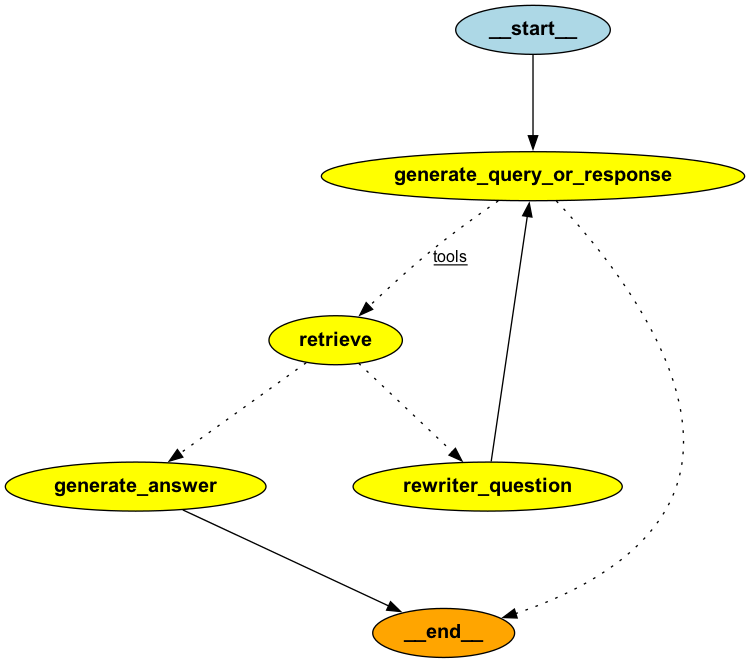

In [12]:
from langgraph.prebuilt import ToolNode, tools_condition

generate_prompt = (
"您是一个问答任务助理。使用以下检索到的上下文片段来回答问题。如果您不知道答案，请直接说不知道。最多使用三句话，并保持回答简洁。\n\n"
"问题: {question} \n"
"上下文: {context} \n"
)

def generate_answer(state:MessagesState):
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = generate_prompt.format(question=question,context=context)
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"messages": [response]}

input = {
    "messages": convert_to_messages(
        [{
            "role":"user",
            "content":"什么是 LangGraph"
        },
        {
            "role":"assistant",
            "content":"",
            "tool_calls":[
                {
                    "id":"1",
                    "name":"retriever_books_tools",
                    "args":{
                        "query":"什么是 LangGraph"
                    }
                }
            ]
        },
        {
            "role":"tool","content":"LangGraph 是一个用于构建有状态的多参与者应用程序的库，利用 LLM 创建代理和多代理工作流.",
            "tool_call_id":"1"
        }]
    )
}
print(generate_answer(input))

workflow = StateGraph(MessagesState)

workflow.add_node("generate_query_or_response",generate_query_or_response)
workflow.add_node("retrieve",ToolNode([]))
workflow.add_node("rewriter_question",rewrite_question)
workflow.add_node("generate_answer",generate_answer)

workflow.add_edge(START,"generate_query_or_response")
workflow.add_conditional_edges(
    "generate_query_or_response",
    tools_condition,
    {
        "tools":"retrieve",
        END:END
    }
)

workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
)
workflow.add_edge("generate_answer",END)
workflow.add_edge("rewriter_question","generate_query_or_response")

graph = workflow.compile()

#可视化图（可选）
from IPython.display import display,Image

try:
    display(Image(graph.get_graph().draw_png()))
except Exception as e:
    pass

# 运行RAG

In [13]:
# 运行 rag
for chunk in graph.stream(
        {
            "messages":[
                {
                    "role": "user",
                    # "content": "什么是 langGraph?"
                    "content": "什么是条件边?"
                }
            ]
        }
):
    for node,update in chunk.items():
        print("upadte from node",node)
        update["messages"][-1].pretty_print()
        print("\n\n")

upadte from node generate_query_or_response
================================== Ai Message ==================================

条件边（Conditional Edge）这个术语在不同的上下文中有不同的含义，但通常出现在图论、概率图模型或者特定的编程语言和框架中。在概率图模型中，比如贝叶斯网络，条件边表示一个节点（随机变量）依赖于另一个节点的状态。也就是说，一个节点的概率分布是基于其父节点状态的条件概率。

如果您是在提到某个具体的领域或上下文中的“条件边”，请提供更多的细节，这样我可以给出更准确的解释。如果您的问题是关于概率图模型或者其他特定领域，请明确指出，以便我能为您提供相关信息。
Tool Calls:
  retriever_books_tools (call_58128221002a4f79af5e35)
 Call ID: call_58128221002a4f79af5e35
  Args:
    query: 条件边



upadte from node retrieve
================================= Tool Message =================================
Name: retriever_books_tools

Error: retriever_books_tools is not a valid tool, try one of [].



upadte from node rewriter_question


AttributeError: 'dict' object has no attribute 'pretty_print'

# 限制敏感词输出

![](./img/3.png)